In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np
rng = np.random.default_rng()

from irc.manager import AgentManager

# Train a rational agent

We first train a rational agent for a given foraging environment. The environment can be specified by a dictionary object or a yaml file.

The example environment is a `irc.examples.IdenticalBoxesEnv` instance, whose parameters are the following:
- $p_\mathrm{appear} \in [0, 1]$: food appear probability.
- $p_\mathrm{vanish} \in [0, 1]$: food vanish probability.
- $p_\mathrm{cue} \in [0, 1]$: color cue parameter. The closer $p_\mathrm{cue}$ is to 0 or 1, the higher discriminability will be.
- $\lambda_\mathrm{center} \in (0, 1)$: vintage point parameter. Greater value means higher discriminability of color cues when viewed at the room center.
- $r_\mathrm{food} \in [0, \infty)$: reward of food.
- $r_\mathrm{move} \in (-\infty, 0]$: reward of moving per unit distance.

The agent we train assumes an environment with parameter $(0.2, 0.05, 0.8, 0.1, 10, -1)$, and updates its belief with respect to the internal environment.

In [2]:
manager = AgentManager(
    defaults='irc_defaults/identical_boxes.yaml',
)
env_param = (0.2, 0.05, 0.8, 0.1, 10., -1.)
num_epochs = 30
agent = manager.train_agent(env_param=env_param, num_epochs=num_epochs)

Checkpoint (epoch 30) loaded.


The snippet above can also be run from command line via `train-one-agent.py`.

# Inspect training progress

We can check the RL training progress of an agent, and assess whether it has reached equilibrium.

Fetching one most trained agent (seed 0) so far (epoch 30).


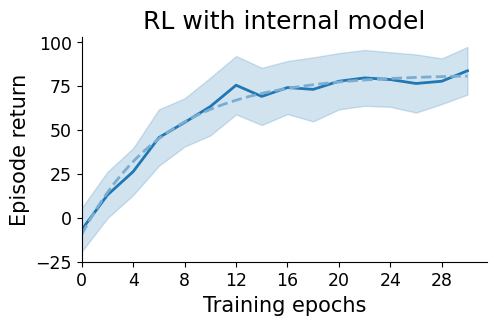

In [3]:
env_param = (0.2, 0.05, 0.8, 0.1, 10., -1.)
agent, fig = manager.inspect_agent(env_param)

Next we run this agent in an environment different from its assumption. At each step, we can also query the agents belief about environment states (with respect to its own assumption). In the two-boxes example below, probabilities of all four possible food availabilty states will be plotted.

In [4]:
from irc.examples import IdenticalBoxesEnv

env = IdenticalBoxesEnv(
    p_appear=0.2, p_vanish=0.1, p_cue=0.7,
)
print(f'Real environment parameter: {tuple(env.get_param())}')
print(f'Assumed environment parameter: {tuple(agent.model.env.get_param())}')

episode = agent.run_one_episode(env=env)

Real environment parameter: (0.2, 0.1, 0.7, 0.1, 10.0, -1.0)
Assumed environment parameter: (0.2, 0.05, 0.8, 0.1, 10.0, -1.0)


Plot probabilities of all four food availability combinations


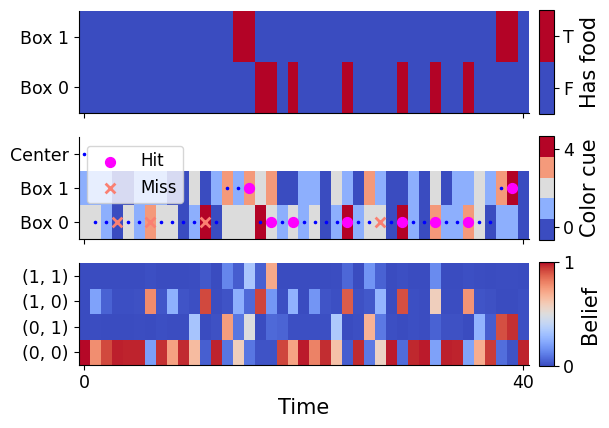

Plot marginal probability of two boxes


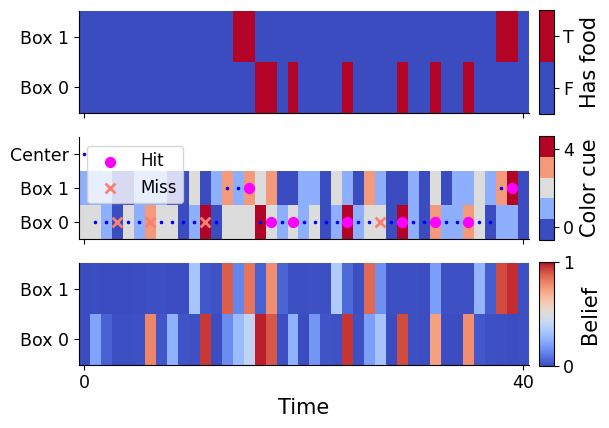

In [5]:
from boxforage.utils import plot_episode

print('Plot probabilities of all four food availability combinations')
fig = plot_episode(episode)

plt.show()

print('Plot marginal probability of two boxes')
fig = plot_episode(episode, plot_marginal=True)

# Train a family of agents defined over a parameter grid

To infer the assumed environment from agent behavior, we first need to prepare a family of agents whose assumed environment parameters are defined by a grid.

We use coupled boxes environment as the assumed environment class. A coupled boxes environment assumes additional 'coupling' stage after the normal independent dynamics of each box. Positive coupling assumes box states will be modified to be the same for random pairs, and negative coupling assumes the otherwise. A parameter grid with various $p_\mathrm{appear}$, $p_\mathrm{vanish}$, $p_\mathrm{cue}$ and the coupling parameter $p_\mathrm{couple}$ are prepared in `param_grids/coupled_boxes.yaml`.

In [6]:
manager = AgentManager(
    defaults='irc_defaults/coupled_boxes.yaml',
)
env_param_grid = 'param_grids/coupled_boxes.yaml'
max_seed = 3 # number of random seeds for agent training

The snippet above can also be run from command line via `sweep-agent-grid.py`. Use command line arguments `count` and `num_epochs` to specify the number of agents to be trained, and the number of epochs to train.

During or after the sweeping over parameter grid, we can check the overall training progress by `overview_agents` method.

In [7]:
min_epoch = 30 # number of training epochs defined as complete
report = manager.overview_agents(
    env_param_grid=env_param_grid, seeds=range(max_seed), min_epoch=min_epoch,
)

Found 530 trained agents.
Average progress of training: 97.9% (30 epochs as complete).
Approximate training time: 3m07.54s per epoch.
Approximate evaluation time: 02.75s.


# Compute likelihood of behavior data conditioned on a trained agent

For a trained agent, we can calculate the likelihood of behavior data $\{o_{[0, T)}, a_{[0, T)}\}$ by first computing the belief traces
$$b_{[0, T)} = B\left(o_{[0, T)}, a_{[0, T)}\right)$$
and then use the agent policy $\pi(a|b)$ to get
$$ P = \prod_{t\in[0, T)} \pi(a_t|b_t)$$

## Prepare behavior data

First we run a trained agent that assuming boxes are coupled in an environment where boxes are actually independent.

In [8]:
in_env_param = (0.2, 0.1, 0.8, 0.1, 10.0, -1.0, -0.4) # environment parameter of internal model
agent, _ = manager.fetch_agent(in_env_param)

env = IdenticalBoxesEnv()
ex_env_param = (0.2, 0.1, 0.8, 0.1, 10.0, -1.0) # environment parameter of actual external world
env.set_param(ex_env_param)

Fetching one most trained agent (seed 4) so far (epoch 50).


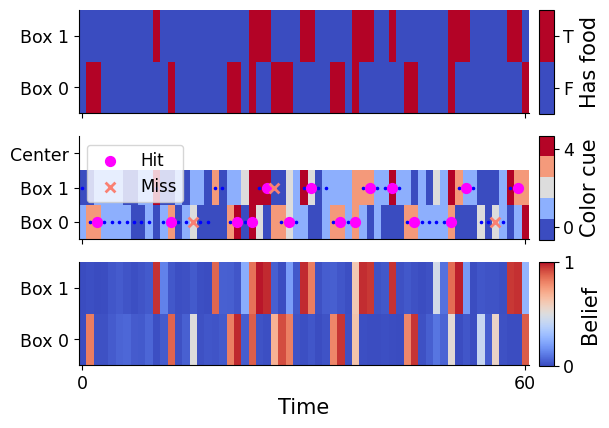

In [9]:
max_steps = 60
seed = 0
episode = agent.run_one_episode(env=env, max_steps=max_steps, seed=seed)
fig = plot_episode(episode, plot_marginal=True)

## Compute likelihoods of actions at each time step

Fetching one most trained agent (seed 9) so far (epoch 50).


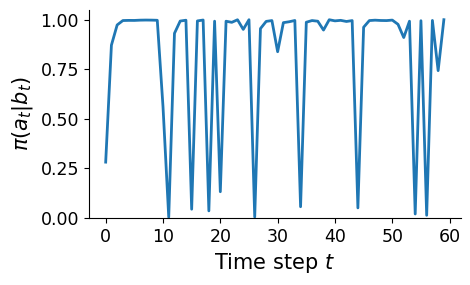

In [10]:
observations = episode['observations']
actions = episode['actions']

guess_env_param = (0.2, 0.05, 0.7, 0.1, 10.0, -1.0, 0.2) # a candidate guess of environment parameter
agent, _ = manager.fetch_agent(guess_env_param)
beliefs, logps = agent.episode_logps(observations, actions)

_, ax = plt.subplots()
ax.plot(np.exp(logps))
ax.set_ylim([0, None])
ax.set_xlabel('Time step $t$')
ax.set_ylabel(r'$\pi(a_t|b_t)$')
plt.show()

# Compute episode likelihood on environment parameter grid

Given a parameter grid, the episode likelihood is first computed for each trained agents, then marginalized over random seeds conditioned on each environment parameter.

In [11]:
counts, logps = manager.compute_logps(
    observations, actions,
    env_param_grid=env_param_grid,
)
print(f'Log likelihoods grid computed, shape {logps.shape}')

1669 trained agents found, computing episode likelihood...
 279/1669 (1m19.99s)
 558/1669 (2m40.62s)
 837/1669 (3m55.83s)
1116/1669 (5m18.73s)
1395/1669 (6m43.01s)
1669/1669 (8m04.16s)
Log likelihoods grid computed, shape (6, 4, 7, 5, 60)


We can also compute likelihoods from command line, if the episode data is already saved in a pickle file.

In [12]:
if isinstance(env_param_grid, str):
    with open(env_param_grid, 'r') as f:
        env_param_grid = yaml.safe_load(f)
params = [v for v in env_param_grid if len(v)>0]

In [13]:
from scipy.special import logsumexp
from irc.utils import logmeanexp

def plot(logps, params):
    n = len(logps.shape)
    fig, axes = plt.subplots(1, n, figsize=(2.5*n, 2), sharey=True, gridspec_kw={'hspace': 0.05})
    for i, ax in enumerate(axes):
        _logps = logmeanexp(logps, axis=tuple(set(range(n))-set([i])))
        logz = logsumexp(_logps)
        ps = np.exp(_logps-logz)
        ax.plot(params[i], ps, marker='x')
    axes[0].set_ylabel(r'$P(\theta|o_{:t}, a_{:t})$')
    return fig, axes

Marginal posterior of parameter using data up to time 10


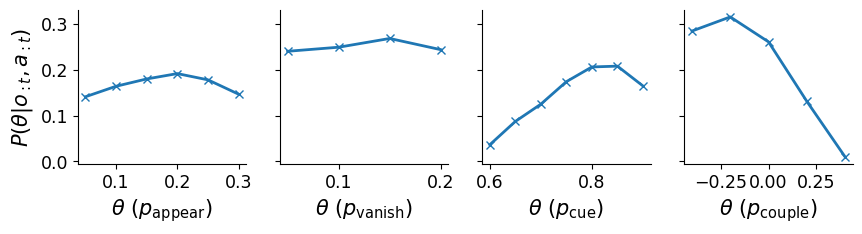

Marginal posterior of parameter using data up to time 20


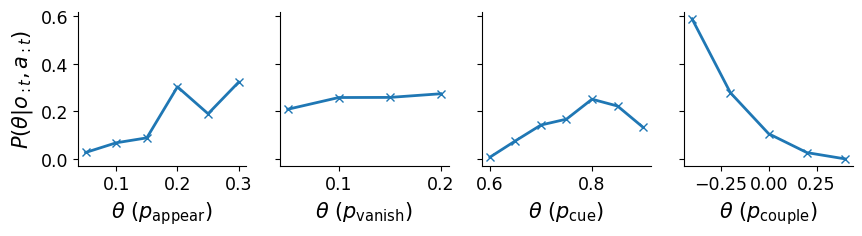

Marginal posterior of parameter using data up to time 30


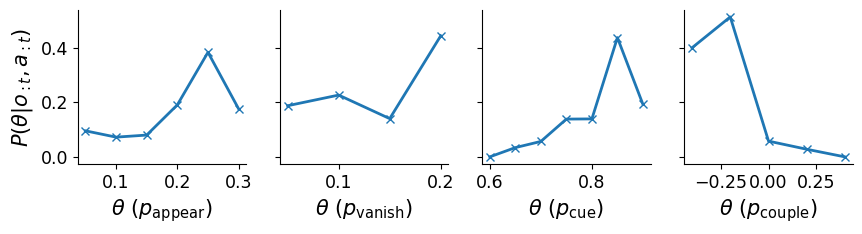

Marginal posterior of parameter using data up to time 40


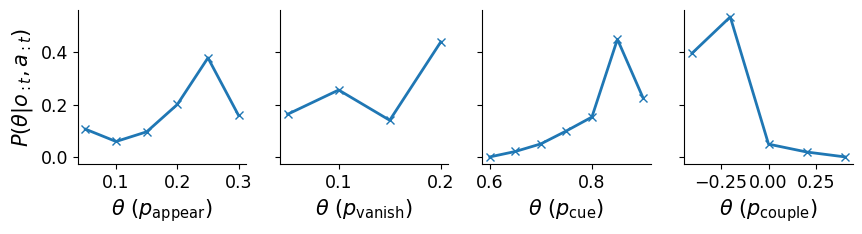

Marginal posterior of parameter using data up to time 50


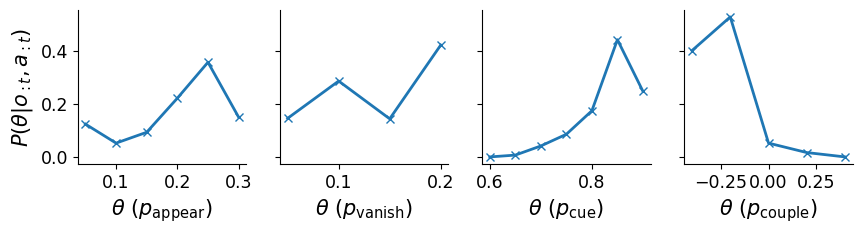

Marginal posterior of parameter using data up to time 60


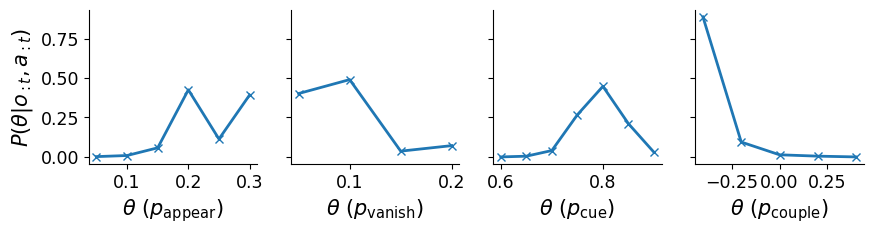

In [14]:
for t in [10, 20, 30, 40, 50, 60]:
    print(f'Marginal posterior of parameter using data up to time {t}')
    fig, axes = plot(np.sum(logps[..., :t], axis=-1), params)
    xlabels = [
        r'$\theta~(p_\mathrm{appear})$', r'$\theta~(p_\mathrm{vanish})$',
        r'$\theta~(p_\mathrm{cue})$', r'$\theta~(p_\mathrm{couple})$',
    ]
    for ax, xlabel in zip(axes, xlabels):
        ax.set_xlabel(xlabel)
    plt.show()